## Momentum Trading Strategy Backtest

**Summary of project:**

### Libraries 

In [4]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import quantstats as qs
import numpy as np
from datetime import datetime, timedelta
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## Importing ETFs 

### **Moving Average Convergence Divergence**





**What is an EMA (Exponential Moving Average):**    

A moving average that puts more weight on recent prices so it reacts faster to new information than a simple moving average. 

For price $P_t$:    
$$
EMA_t = {\alpha}P_t+(1-\alpha)EMA_{t-1}
$$
where   
$$
\alpha =\frac{2}{N+1}
$$ 

and N is the lookback window, typically 12 days (fast EMA- half trading month) or 26 days (slow EMA- full trading month).


**Features**:
- The weight on prices decays so that observaions older than about N period contribute very little
- Each day back gets less importance than the day after it, so a 12 day or 26 day EMA still includes prices before that






**Advantages**

- EMA responds faster to recent price changes as today's weight has a big weight
- Simple moving average (SMA) would need days to notice

**MACD Line**    
- Measures momentum by asking if price rising daster now than it was recently by comparin a fast reaction to a slow reaction to price.
- The MACD line is defined by   

$$  
MACD = EMA_{12} - EMA_{26}  
$$


Interpretation of MACD as a momentum gap (divergence) : 
- MACD > 0 $\rightarrow$ to short-term momentum > long-term momentum (bullish signal)
- MACD < 0 $\rightarrow$ short-term momentum < long-term momentum (bearish signal)

**Step 1: Extract Apple Data**
    

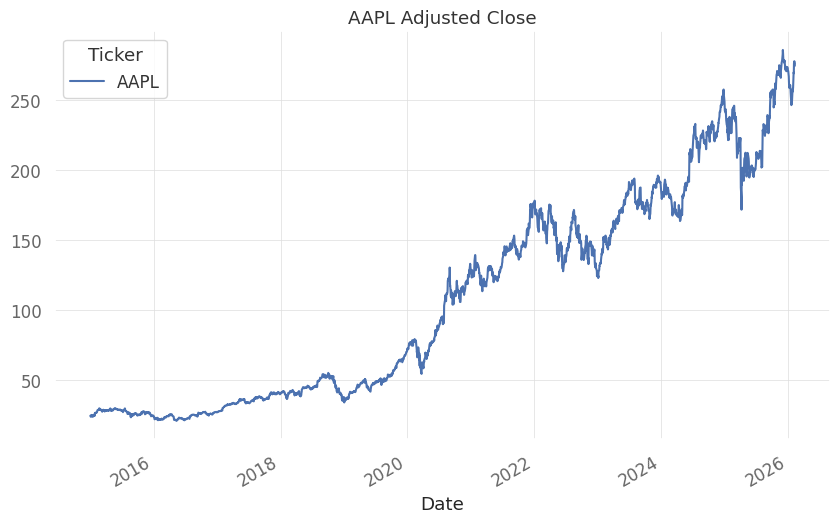

In [19]:
#Download Apple price data  
aapl = yf.download(
    "AAPL", 
    start = "2015-01-01",
    auto_adjust = True, #to adjust prices for dividends and splits
    progress = False #to print progress bar while downloading data
)

prices = aapl["Close"]
prices.plot(title="AAPL Adjusted Close")
plt.show()

**Step 2: Compute MACD**


In [20]:
# 1) Compute fast EMA and slow EMA respectively
ema12 = prices.ewm(span = 12, adjust = False).mean() #ewm is the exponential weithed view of the price series
ema26 = prices.ewm(span = 26, adjust = False).mean()

# 2) MACD line
macd = ema12 - ema26

#3) Signal line (9 day EMA of the MACD line)
signal = macd.ewm(span = 9, adjust = False).mean()

#4) Histogram
histogram = macd - signal

#5) Basic trading signals
bullish_cross = (macd > signal) & (macd.shift(1) <= signal.shift(1))
bearish_cross = (macd < signal) & (macd.shift(1) >= signal.shift(1))

print("Bullish signals:", bullish_cross.sum())
print("Bearish signals:", bearish_cross.sum())


Bullish signals: Ticker
AAPL    100
dtype: int64
Bearish signals: Ticker
AAPL    100
dtype: int64


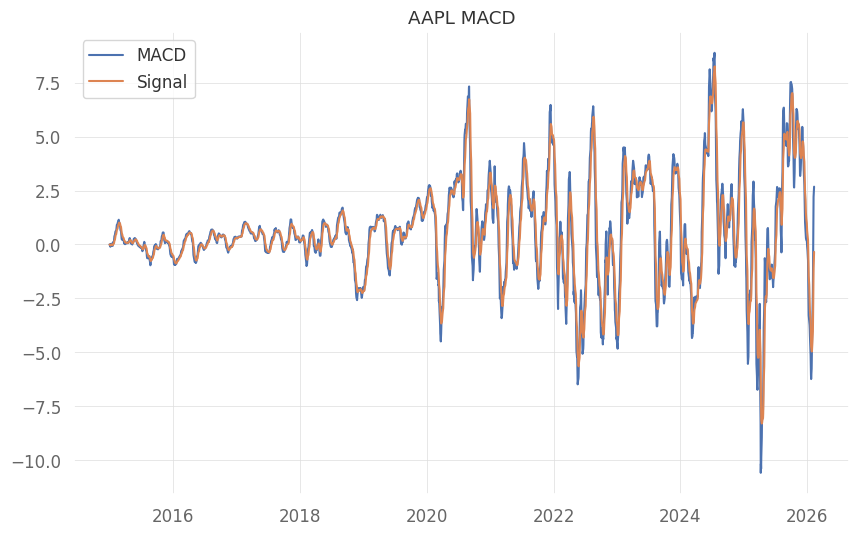

In [21]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(macd, label="MACD")
plt.plot(signal, label="Signal")
plt.legend()
plt.title("AAPL MACD")
plt.show()


ticker: AAPL
start: 2015-01-01
end: 2026-02-09
initial_capital: 1000000.000000
ending_value_strategy: 7576671.999927
ending_value_buyhold: 11340952.362948
profit_strategy: 6576671.999927
profit_pct_strategy: 6.576672
max_drawdown_strategy: -0.270335
trades: 199
fee_rate_per_trade: 0.000500


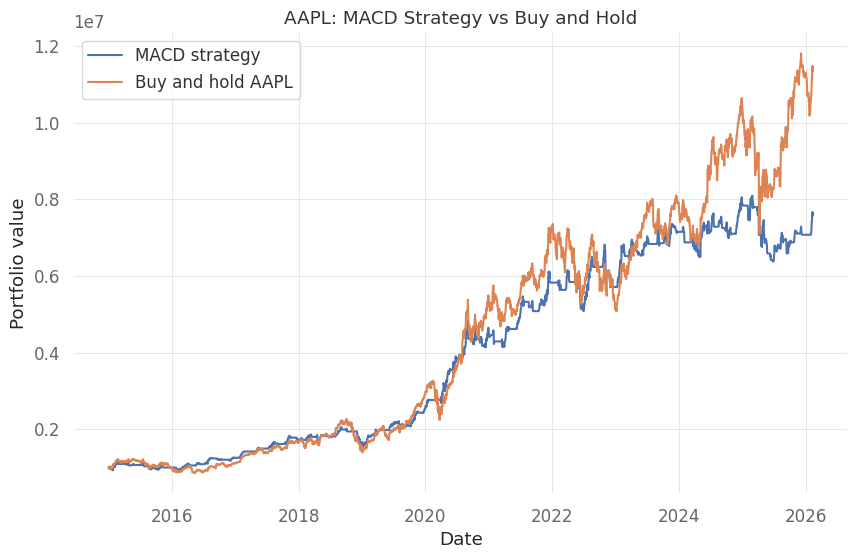

In [24]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_macd(
    ticker: str = "AAPL",
    start: str = "2015-01-01",
    initial_capital: float = 1_000_000.0,
    fast_span: int = 12,
    slow_span: int = 26,
    signal_span: int = 9,
    fee_rate_per_trade: float = 0.0005
):
    data = yf.download(
        ticker,
        start=start,
        auto_adjust=True,
        progress=False
    )

    close = data["Close"]
    if isinstance(close, pd.DataFrame):
        close = close.iloc[:, 0]
    prices = close.dropna().astype(float)

    ema_fast = prices.ewm(span=fast_span, adjust=False).mean()
    ema_slow = prices.ewm(span=slow_span, adjust=False).mean()
    macd = ema_fast - ema_slow
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    hist = macd - signal

    raw_position = (macd > signal).astype(int)
    position = raw_position.shift(1).fillna(0).astype(int)

    returns = prices.pct_change().fillna(0.0)
    trades = position.diff().abs().fillna(0.0)

    strategy_returns_gross = position * returns
    strategy_returns_net = strategy_returns_gross - trades * fee_rate_per_trade

    equity_strategy = initial_capital * (1.0 + strategy_returns_net).cumprod()

    # Buy-and-hold benchmark (same initial capital)
    equity_buyhold = initial_capital * (prices / prices.iloc[0])

    final_value = float(equity_strategy.iloc[-1])
    profit = final_value - initial_capital
    profit_pct = final_value / initial_capital - 1.0

    running_max = equity_strategy.cummax()
    drawdown = equity_strategy / running_max - 1.0
    max_drawdown = float(drawdown.min())

    results = {
        "ticker": ticker,
        "start": start,
        "end": str(equity_strategy.index[-1].date()),
        "initial_capital": float(initial_capital),
        "ending_value_strategy": float(equity_strategy.iloc[-1]),
        "ending_value_buyhold": float(equity_buyhold.iloc[-1]),
        "profit_strategy": float(profit),
        "profit_pct_strategy": float(profit_pct),
        "max_drawdown_strategy": float(max_drawdown),
        "trades": int(trades.sum()),
        "fee_rate_per_trade": float(fee_rate_per_trade),
    }

    return prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results


# ---- Run ----
prices, macd, signal, hist, position, equity_strategy, equity_buyhold, results = backtest_macd(
    ticker="AAPL",
    start="2015-01-01",
    initial_capital=1_000_000.0,
    fee_rate_per_trade=0.0005
)

for k, v in results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.6f}")
    else:
        print(f"{k}: {v}")

# ---- Plot: strategy vs buy-and-hold ----
plt.figure()
plt.plot(equity_strategy, label="MACD strategy")
plt.plot(equity_buyhold, label="Buy and hold AAPL")
plt.title("AAPL: MACD Strategy vs Buy and Hold")
plt.xlabel("Date")
plt.ylabel("Portfolio value")
plt.legend()
plt.show()




WHYY????

Stress tests
2020 type crash, 2022 rates shock -> this MACD method do good here???

In [39]:
import numpy as np
import pandas as pd
import yfinance as yf

def get_prices(tickers, start="2005-01-01", end=None):
    px = yf.download(
        tickers=tickers,
        start=start,
        end=end,
        auto_adjust=True,
        progress=False
    )["Close"]
    if isinstance(px, pd.Series):
        px = px.to_frame()
    px.index = pd.to_datetime(px.index)
    px = px.dropna(how="all")
    return px

def ewma_vol_annualized(daily_returns, span_days=60, trading_days=252):
    vol_daily = daily_returns.ewm(span=span_days, adjust=False).std()
    return vol_daily * np.sqrt(trading_days)

def equity_regime_filter(prices_daily, market_ticker=None, ma_days=200):
    if market_ticker is None:
        market_ticker = prices_daily.columns[0]
    if market_ticker not in prices_daily.columns:
        market_ticker = prices_daily.columns[0]

    mkt = prices_daily[market_ticker]
    ma = mkt.rolling(ma_days).mean()
    regime_daily = (mkt > ma).astype(int)

    regime_m = regime_daily.resample("ME").last()
    regime_m = regime_m.shift(1)
    return regime_m

def performance_summary(monthly_returns):
    r = monthly_returns.dropna()
    if r.empty:
        return {
            "ann_return": np.nan,
            "ann_vol": np.nan,
            "sharpe": np.nan,
            "max_drawdown": np.nan,
            "months": 0
        }

    total_growth = (1.0 + r).prod()
    months = len(r)
    ann_return = total_growth ** (12.0 / months) - 1.0
    ann_vol = r.std(ddof=0) * np.sqrt(12.0)
    sharpe = np.nan if ann_vol == 0 else ann_return / ann_vol

    equity = (1.0 + r).cumprod()
    peak = equity.cummax()
    drawdown = (equity / peak) - 1.0
    max_dd = drawdown.min()

    return {
        "ann_return": float(ann_return),
        "ann_vol": float(ann_vol),
        "sharpe": float(sharpe),
        "max_drawdown": float(max_dd),
        "months": int(months)
    }

def leverage_to_target_vol(monthly_returns, target_vol=0.15, vol_lookback=36, max_leverage=3.0):
    r = monthly_returns.dropna()
    realised_vol = r.rolling(vol_lookback).std() * np.sqrt(12.0)
    lev = (target_vol / realised_vol).shift(1)
    lev = lev.clip(upper=max_leverage)
    return lev * r

def apply_transaction_costs(monthly_returns, turnover_series, cost_per_turnover=0.001):
    """
    cost_per_turnover: 0.001 means 10 bps cost per 100% turnover in that month
    """
    r, to = monthly_returns.align(turnover_series, join="inner")
    return r - cost_per_turnover * to

def slice_period(monthly_returns, start, end):
    return monthly_returns.loc[start:end]

def backtest_tsmom(
    prices_daily,
    lookback_months=12,
    skip_months=1,
    ewma_span_days=60,
    target_annual_vol=0.10,
    long_only=True,
    use_regime_filter=True,
    regime_market_ticker=None,
    regime_ma_days=200,
    use_signal_to_noise=True,
    signal_clip=3.0,
    vol_floor=1e-6,
    max_abs_position=0.20,
    cost_per_turnover=0.001
):
    prices_daily = prices_daily.copy()
    prices_daily.index = pd.to_datetime(prices_daily.index)

    rets_daily = prices_daily.pct_change()

    prices_m = prices_daily.resample("ME").last()
    rets_m = prices_m.pct_change()

    mom = (prices_m / prices_m.shift(lookback_months)) - 1.0

    vol_a_daily = ewma_vol_annualized(rets_daily, span_days=ewma_span_days)
    vol_a_m = vol_a_daily.resample("ME").last()
    vol_a_m_lag = vol_a_m.shift(skip_months)
    vol_safe = vol_a_m_lag.clip(lower=vol_floor)

    if use_signal_to_noise:
        raw_signal = (mom / vol_safe).shift(skip_months)
        signal = raw_signal.clip(lower=-signal_clip, upper=signal_clip)
    else:
        signal = np.sign(mom).shift(skip_months)

    if long_only:
        signal = signal.clip(lower=0)

    position = signal * (target_annual_vol / vol_safe)

    if use_regime_filter:
        regime = equity_regime_filter(prices_daily, market_ticker=regime_market_ticker, ma_days=regime_ma_days)
        position = position.mul(regime, axis=0)

    position = position.clip(lower=-max_abs_position, upper=max_abs_position)

    gross_port_ret_m = (position * rets_m).mean(axis=1)

    turnover = position.diff().abs().sum(axis=1)
    avg_turnover = float(turnover.dropna().mean()) if turnover.dropna().size else np.nan

    net_port_ret_m = apply_transaction_costs(gross_port_ret_m, turnover, cost_per_turnover=cost_per_turnover)

    return {
        "gross_monthly_returns": gross_port_ret_m,
        "net_monthly_returns": net_port_ret_m,
        "positions": position,
        "signals": signal,
        "vol_annual_lag": vol_a_m_lag,
        "asset_monthly_returns": rets_m,
        "turnover_series": turnover,
        "avg_monthly_turnover": avg_turnover
    }

if __name__ == "__main__":
    etfs = ["VTI", "QQQ", "IWM", "VEA", "VWO", "BND", "TLT", "GLD"]
    stocks = ["AAPL", "MSFT", "AMZN", "GOOGL", "META", "NVDA", "JPM", "XOM", "UNH", "PG"]
    tickers = etfs + stocks

    prices = get_prices(tickers, start="2015-01-01", end="2026-01-01")

    res = backtest_tsmom(
        prices,
        lookback_months=12,
        skip_months=1,
        ewma_span_days=60,
        target_annual_vol=0.10,
        long_only=True,
        use_regime_filter=True,
        regime_market_ticker="VTI",
        regime_ma_days=200,
        use_signal_to_noise=True,
        signal_clip=3.0,
        max_abs_position=0.20,
        cost_per_turnover=0.001
    )

    print("Gross stats:", performance_summary(res["gross_monthly_returns"]))
    print("Net stats:", performance_summary(res["net_monthly_returns"]))
    print("Average monthly turnover:", res["avg_monthly_turnover"])

    levered_net = leverage_to_target_vol(res["net_monthly_returns"], target_vol=0.15, vol_lookback=36, max_leverage=3.0)
    print("Levered net stats:", performance_summary(levered_net))

    covid_period = slice_period(res["net_monthly_returns"], "2020-02-01", "2020-06-30")
    print("COVID net stats:", performance_summary(covid_period))

    inflation_2022 = slice_period(res["net_monthly_returns"], "2022-01-01", "2022-12-31")
    print("2022 net stats:", performance_summary(inflation_2022))


Gross stats: {'ann_return': 0.023401744552510317, 'ann_vol': 0.015578549689016369, 'sharpe': 1.5021773540966834, 'max_drawdown': -0.014031565350799413, 'months': 119}
Net stats: {'ann_return': 0.017209181848450994, 'ann_vol': 0.01575199009722909, 'sharpe': 1.0925084222518802, 'max_drawdown': -0.022266555489302675, 'months': 119}
Average monthly turnover: 0.45652537095599477
Levered net stats: {'ann_return': 0.04290281800573559, 'ann_vol': 0.04686188291981892, 'sharpe': 0.915516307339649, 'max_drawdown': -0.050091655442152994, 'months': 83}
COVID net stats: {'ann_return': -0.017375874264337732, 'ann_vol': 0.013821095362683472, 'sharpe': -1.257199506144213, 'max_drawdown': -0.0032528635936021066, 'months': 5}
2022 net stats: {'ann_return': -0.010266811825379252, 'ann_vol': 0.006692192412383231, 'sharpe': -1.534147734064183, 'max_drawdown': -0.0035350795849047323, 'months': 12}
